In [1]:
from datetime import date
from glob import glob
import os, sys
from os.path import join, dirname
from tqdm import tqdm
import string

import pickle as pkl
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.stats.multitest

import matplotlib.pyplot as plt
from matplotlib import cm, colors, patches, lines

from scipy import optimize, stats

from nilearn import image, plotting, masking
from nilearn.maskers import NiftiLabelsMasker

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

# import pingouin as pg

import random
# from random import random as rand

import re

In [2]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

In [3]:
dir_root = join('/mnt/ext5/GP/fmri_data')
dir_stat = join(dir_root,'stats/AM/GLM.reward_per_trial/5.0s_shifted')
dir_mask = join(dir_root,'masks')

In [4]:
list_dlPFC_cTBS = [
    '09', '10', '18', '21', '22'
    , '24', '27', '34', '35', '36'
    , '38', '42', '57', '59', '62'
    , '66', '67'
]
list_M1_cTBS = [
    '08', '11', '17', '19', '20'
    , '26', '32', '33', '37', '39'
    , '40', '41', '56', '58', '61'
    , '63', '65'
]
## GP50은 GP26과 동일인물
list_dlPFC_20Hz = [
    '43', '44', '45', '46', '47'
    , '48', '49', '51', '53', '54'
    , '55'
#     , '50'
]
list_subj = sorted(list_dlPFC_cTBS+list_M1_cTBS+list_dlPFC_20Hz)

In [5]:
list_GA = []
list_ = glob(join('/mnt/ext5/GA/fmri_data/raw_data/GA??'))
for dname in list_:
    list_GA.append(dname.split('/')[-1])

In [6]:
dx = pd.DataFrame(index=list_GA)
dx['group'] = 'no_stim'

In [7]:
dy = pd.DataFrame()
for nn in list_subj:
    subj = 'GP%s'%nn
    group = 'DLPFC_cTBS' if nn in list_dlPFC_cTBS else ('M1_cTBS' if nn in list_M1_cTBS else 'DLPFC_20Hz')
    new_row = pd.Series(data=group, name=subj)

    dy = pd.concat(
        [dy, new_row.to_frame().T]
        , axis='index'
        , ignore_index=False
    )
dy = dy.rename({0:'group'}, axis='columns')

In [8]:
dz = pd.concat([dx, dy])
del dx, dy
dz

group
GA01     no_stim
GA35     no_stim
GA26     no_stim
GA02     no_stim
GA18     no_stim
...          ...
GP62  DLPFC_cTBS
GP63     M1_cTBS
GP65     M1_cTBS
GP66  DLPFC_cTBS
GP67  DLPFC_cTBS

[75 rows x 1 columns]

---

In [9]:
p_thresh = 5.e-2
thresh = stats.norm.isf(0.5*p_thresh)

In [10]:
view_cut = {}
view_cut['sagittal'] = [-55, -22, -7]
view_cut['axial'] = [2]

In [ ]:
nrows, ncols = 4, 4
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2.4*ncols,2.6*nrows), dpi=300)

run = 'r03'

for ii, group in enumerate(['no_stim', 'DLPFC_cTBS', 'M1_cTBS', 'DLPFC_20Hz']):
    for jj, coord in enumerate(view_cut['sagittal']):
        ax = axs[ii][jj]
        if group =='no_stim':
            fname_Zscr = glob(join(
                '/mnt/ext5/GA/fmri_data/stats/AM/GLM.reward_per_trial/5.0s_shifted'
                , 'Zstat.%s.prac.n??.nii'%run
            ))[0]
        else:
            fname_Zscr = glob(join(dir_stat,'Zstat.%s.%s.n??.nii'%(run,group)))[0]

#         ## positive
#         img_stat = image.math_img(
#             img1=fname_Zscr
#             , formula='(img1>0) * img1'
#         )

        ## positive & negative
        img_stat = fname_Zscr

        g = plotting.plot_stat_map(
            img_stat
            , threshold=thresh
            , display_mode='x'
            , black_bg=False
            , cut_coords=[coord]
            , vmax=6.5
            , cmap='jet', colorbar=False
            , axes=ax
        )
    for kk, coord in enumerate(view_cut['axial']):
        ax = axs[ii][jj+1+kk]

        ## positive & negative
        img_stat = fname_Zscr

        g = plotting.plot_stat_map(
            img_stat
            , threshold=thresh
            , display_mode='z'
            , black_bg=False
            , cut_coords=[coord]
            , vmax=6.5
            , cmap='jet', colorbar=False
            , axes=ax
        )

## 최대 최소 설정
vmax = 6.5
vmin = -6.5
norm = colors.Normalize(vmin=vmin, vmax=vmax)

################
## upper cmap ##
################

### 컬러바 생성
array_cmap = cm.jet(range(cm.jet.N))[int(norm(thresh)*256):]
cmap_new = colors.ListedColormap(array_cmap)
colormapping = cm.ScalarMappable(
    norm=colors.Normalize(vmin=thresh, vmax=vmax)
    , cmap=cmap_new
)
### 컬러바 삽입
# cax = fig.add_axes([0.05, .15, .015, .7])
cax = fig.add_axes([0.0, 0.55, .03, 0.3])
cbar = fig.colorbar(
    colormapping, extend='max'
    , orientation='vertical'
    , format='%.2f'
    , cax=cax)

################
## lower cmap ##
################

### 컬러바 생성
array_cmap = cm.jet(range(cm.jet.N))[:int(norm(-thresh)*256)]
cmap_new = colors.ListedColormap(array_cmap)
colormapping = cm.ScalarMappable(
    norm=colors.Normalize(vmin=vmin, vmax=-thresh)
    , cmap=cmap_new
)
### 컬러바 삽입
# cax = fig.add_axes([0.05, .15, .015, .7])
cax = fig.add_axes([0.0, 0.15, .03, 0.3])
cbar = fig.colorbar(
    colormapping, extend='min'
    , orientation='vertical'
    , format='%.2f'
    , cax=cax
)

## labeling
palette = cm.turbo(np.linspace(0.1,1.0,4))

dy = 0.20
## titles
for ii, group in enumerate(['No stim',r'DLPFC$_{cTBS}$',r'M1$_{cTBS}$',r'DLPFC$_{20Hz}$']):
    fig.text(
        0.95, 0.8-dy*ii, group
        , size=15, rotation=0
        , ha='left', va='center'
        , color='white', fontweight='bold'
        , bbox=dict(
            boxstyle='round'
            , ec=(0.4, 0.4, 0.4)
            , fc=palette[ii]
        )
    )
    
fig.tight_layout()

In [ ]:
fig.set_size_inches(2.4*ncols,2.6*nrows)
fig.savefig(
    '/home/sungbeenpark/Github/labs/GP/results/fMRI.fig_3-a.%s.png'%run
    , dpi=300, facecolor=[1,1,1,1]
    , bbox_inches = 'tight'
)

---

Animation

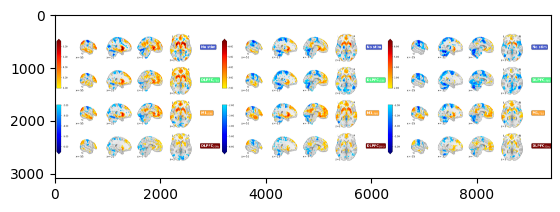

In [52]:
from PIL import Image
from matplotlib import animation

# Load the three images
img1 = Image.open('/home/sungbeenpark/Github/labs/GP/results/fMRI.fig_3-a.r01.png')
img2 = Image.open('/home/sungbeenpark/Github/labs/GP/results/fMRI.fig_3-a.r02.png')
img3 = Image.open('/home/sungbeenpark/Github/labs/GP/results/fMRI.fig_3-a.r03.png')

# 이미지를 NumPy 배열로 변환합니다.
arr1 = np.array(img1)
arr2 = np.array(img2)
arr3 = np.array(img3)

# 이미지를 연결하여 새로운 이미지를 만듭니다.
concat_arr = np.concatenate((arr1, arr2, arr3), axis=1)

# 애니메이션을 생성합니다.
fig, ax = plt.subplots()
im = ax.imshow(concat_arr)

# 각 프레임을 업데이트하는 함수를 정의합니다.
def update(frame):
    return im.set_array(concat_arr)

# 애니메이션 객체를 생성합니다.
ani = animation.FuncAnimation(fig, update, frames=range(10), interval=200)

# 애니메이션을 보여줍니다.
plt.show()

---

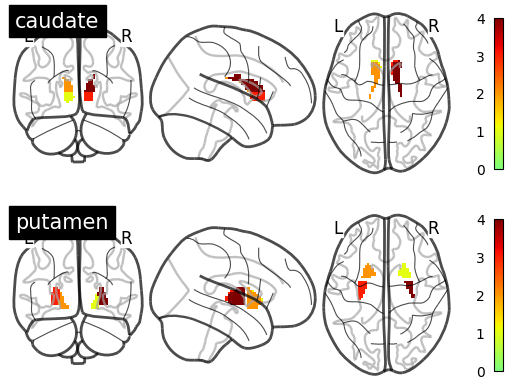

In [10]:
fig, axs = plt.subplots(nrows=2)

imgs = {}
for ii, roi in enumerate(['caudate','putamen']):
    ax = axs[ii]
    imgs[roi] = image.load_img(
        join(dir_mask,'mask.TTatlas.%s.resampled.nii'%roi),
    )
    plotting.plot_glass_brain(
        imgs[roi],
        title=roi,
        cmap=cm.jet, colorbar=True,
        axes=ax
    )

In [11]:
img_mask = image.math_img(
    img1=imgs['putamen'], img2=imgs['caudate']
    , formula='img1 + (img2+4)*(img2>0)'
)

In [ ]:
plotting.view_img(
    img_mask,
    cmap=cm.jet.resampled(9), colorbar=True, symmetric_cmap=False,
    resampling_interpolation='nearest'
)

In [ ]:
labels=[
    'raPU', 'laPU', 'lpPU', 'rpPU',
    'laCA', 'lpCA', 'raCA', 'rpCA'
]
masker = NiftiLabelsMasker(
    labels_img=img_mask, labels=labels,
    memory='/home/sungbeenpark/trash/nilearn_cashe', verbose=0
)

/home/sungbeenpark/.local/lib/python3.10/site-packages/nilearn/plotting/img_plotting.py:572: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  img = new_img_like(roi_img, data, affine=roi_img.affine)
/tmp/ipykernel_169994/160058152.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


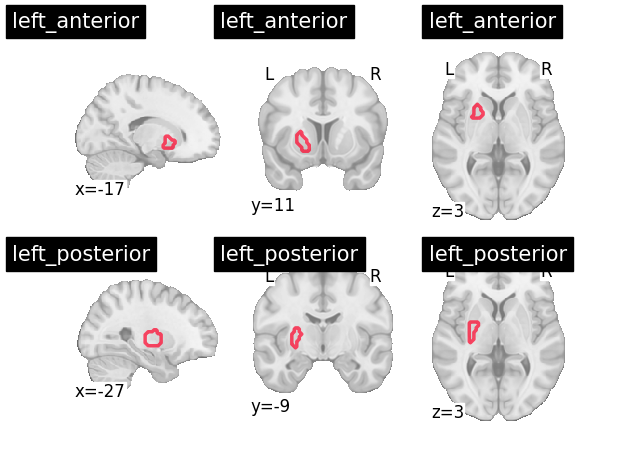

In [38]:
# fig, axs = plt.subplots(nrows=2, ncols=3)

# coord = [[-17,11,3], [-27,-9,3]]
# for ii, (roi, img) in enumerate(imgs.items()):
#     for jj, axis in enumerate(['x','y','z']):
#         ax = axs[ii][jj]
#         plotting.plot_roi(
#             img, black_bg=False
#             , display_mode=axis
#             , cut_coords=[coord[ii][jj]], draw_cross=False
#             , view_type='contours', linewidths=2.5
#             , cmap='gist_rainbow'
#             , title=roi
#             , axes=ax
#         )
# fig.tight_layout()

---

In [16]:
p_thresh = 5.e-2
thresh = stats.norm.isf(0.5*p_thresh)

In [17]:
run='r01'

/usr/local/fsl/lib/python3.10/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



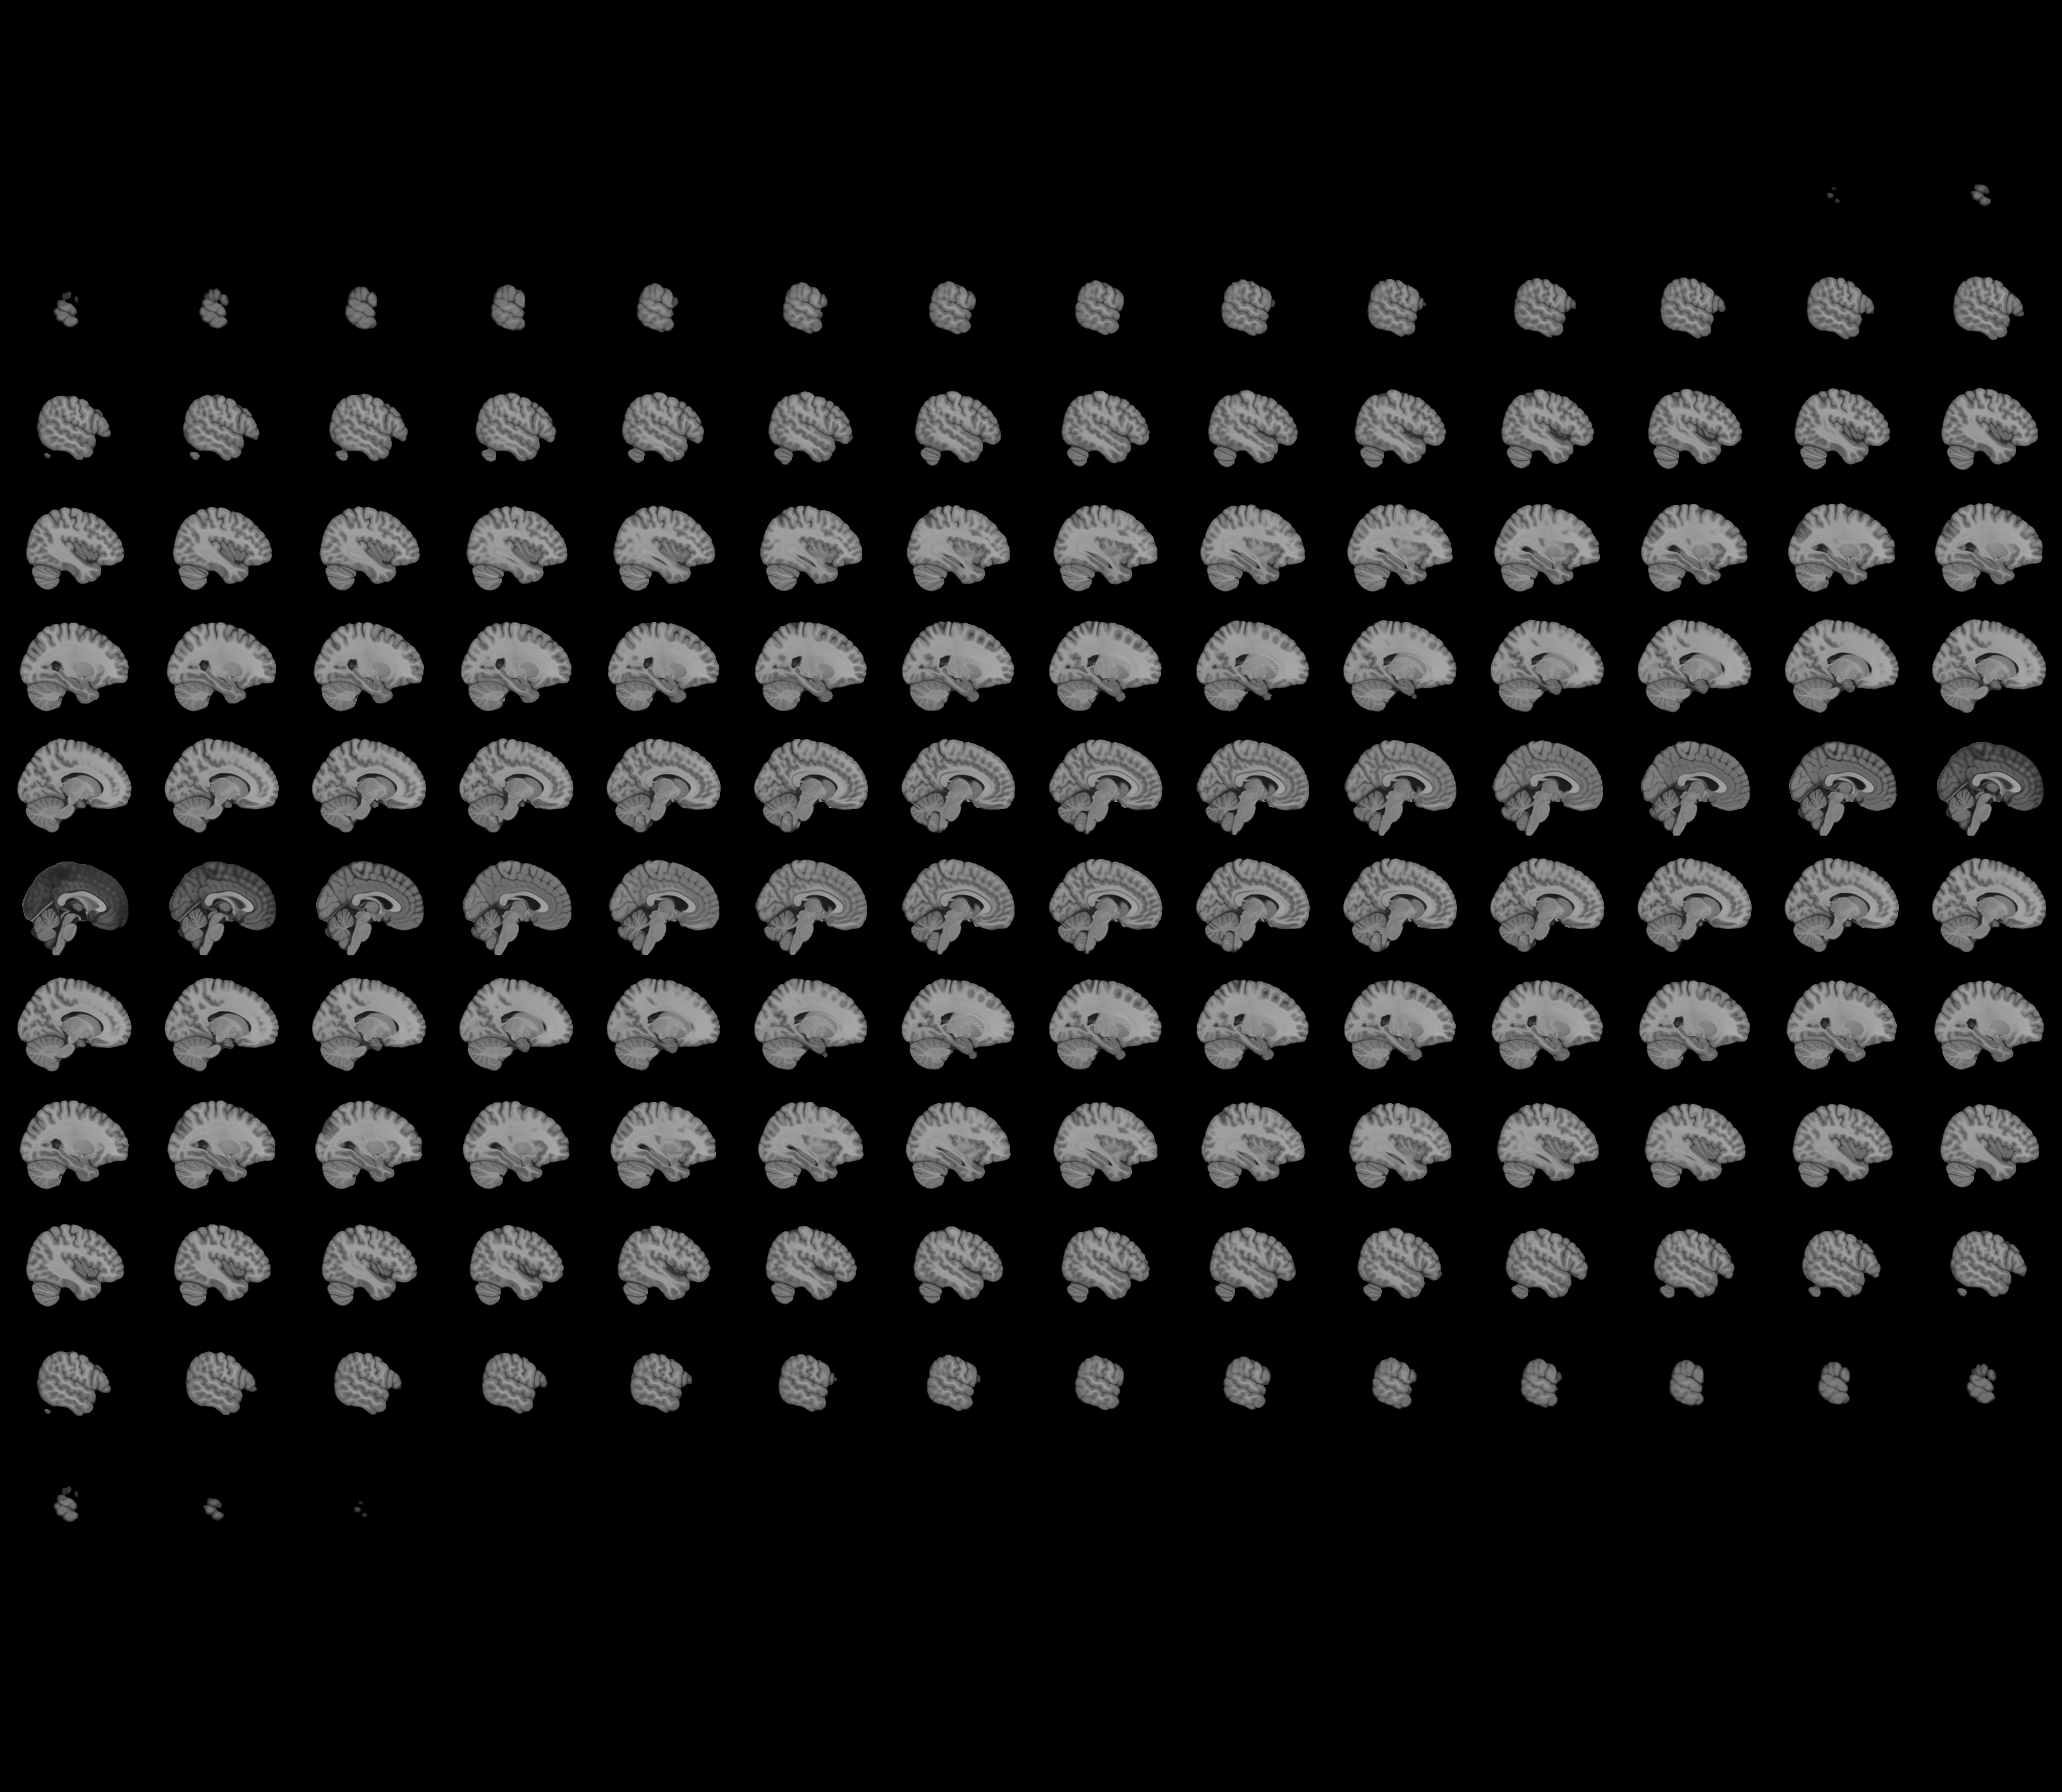
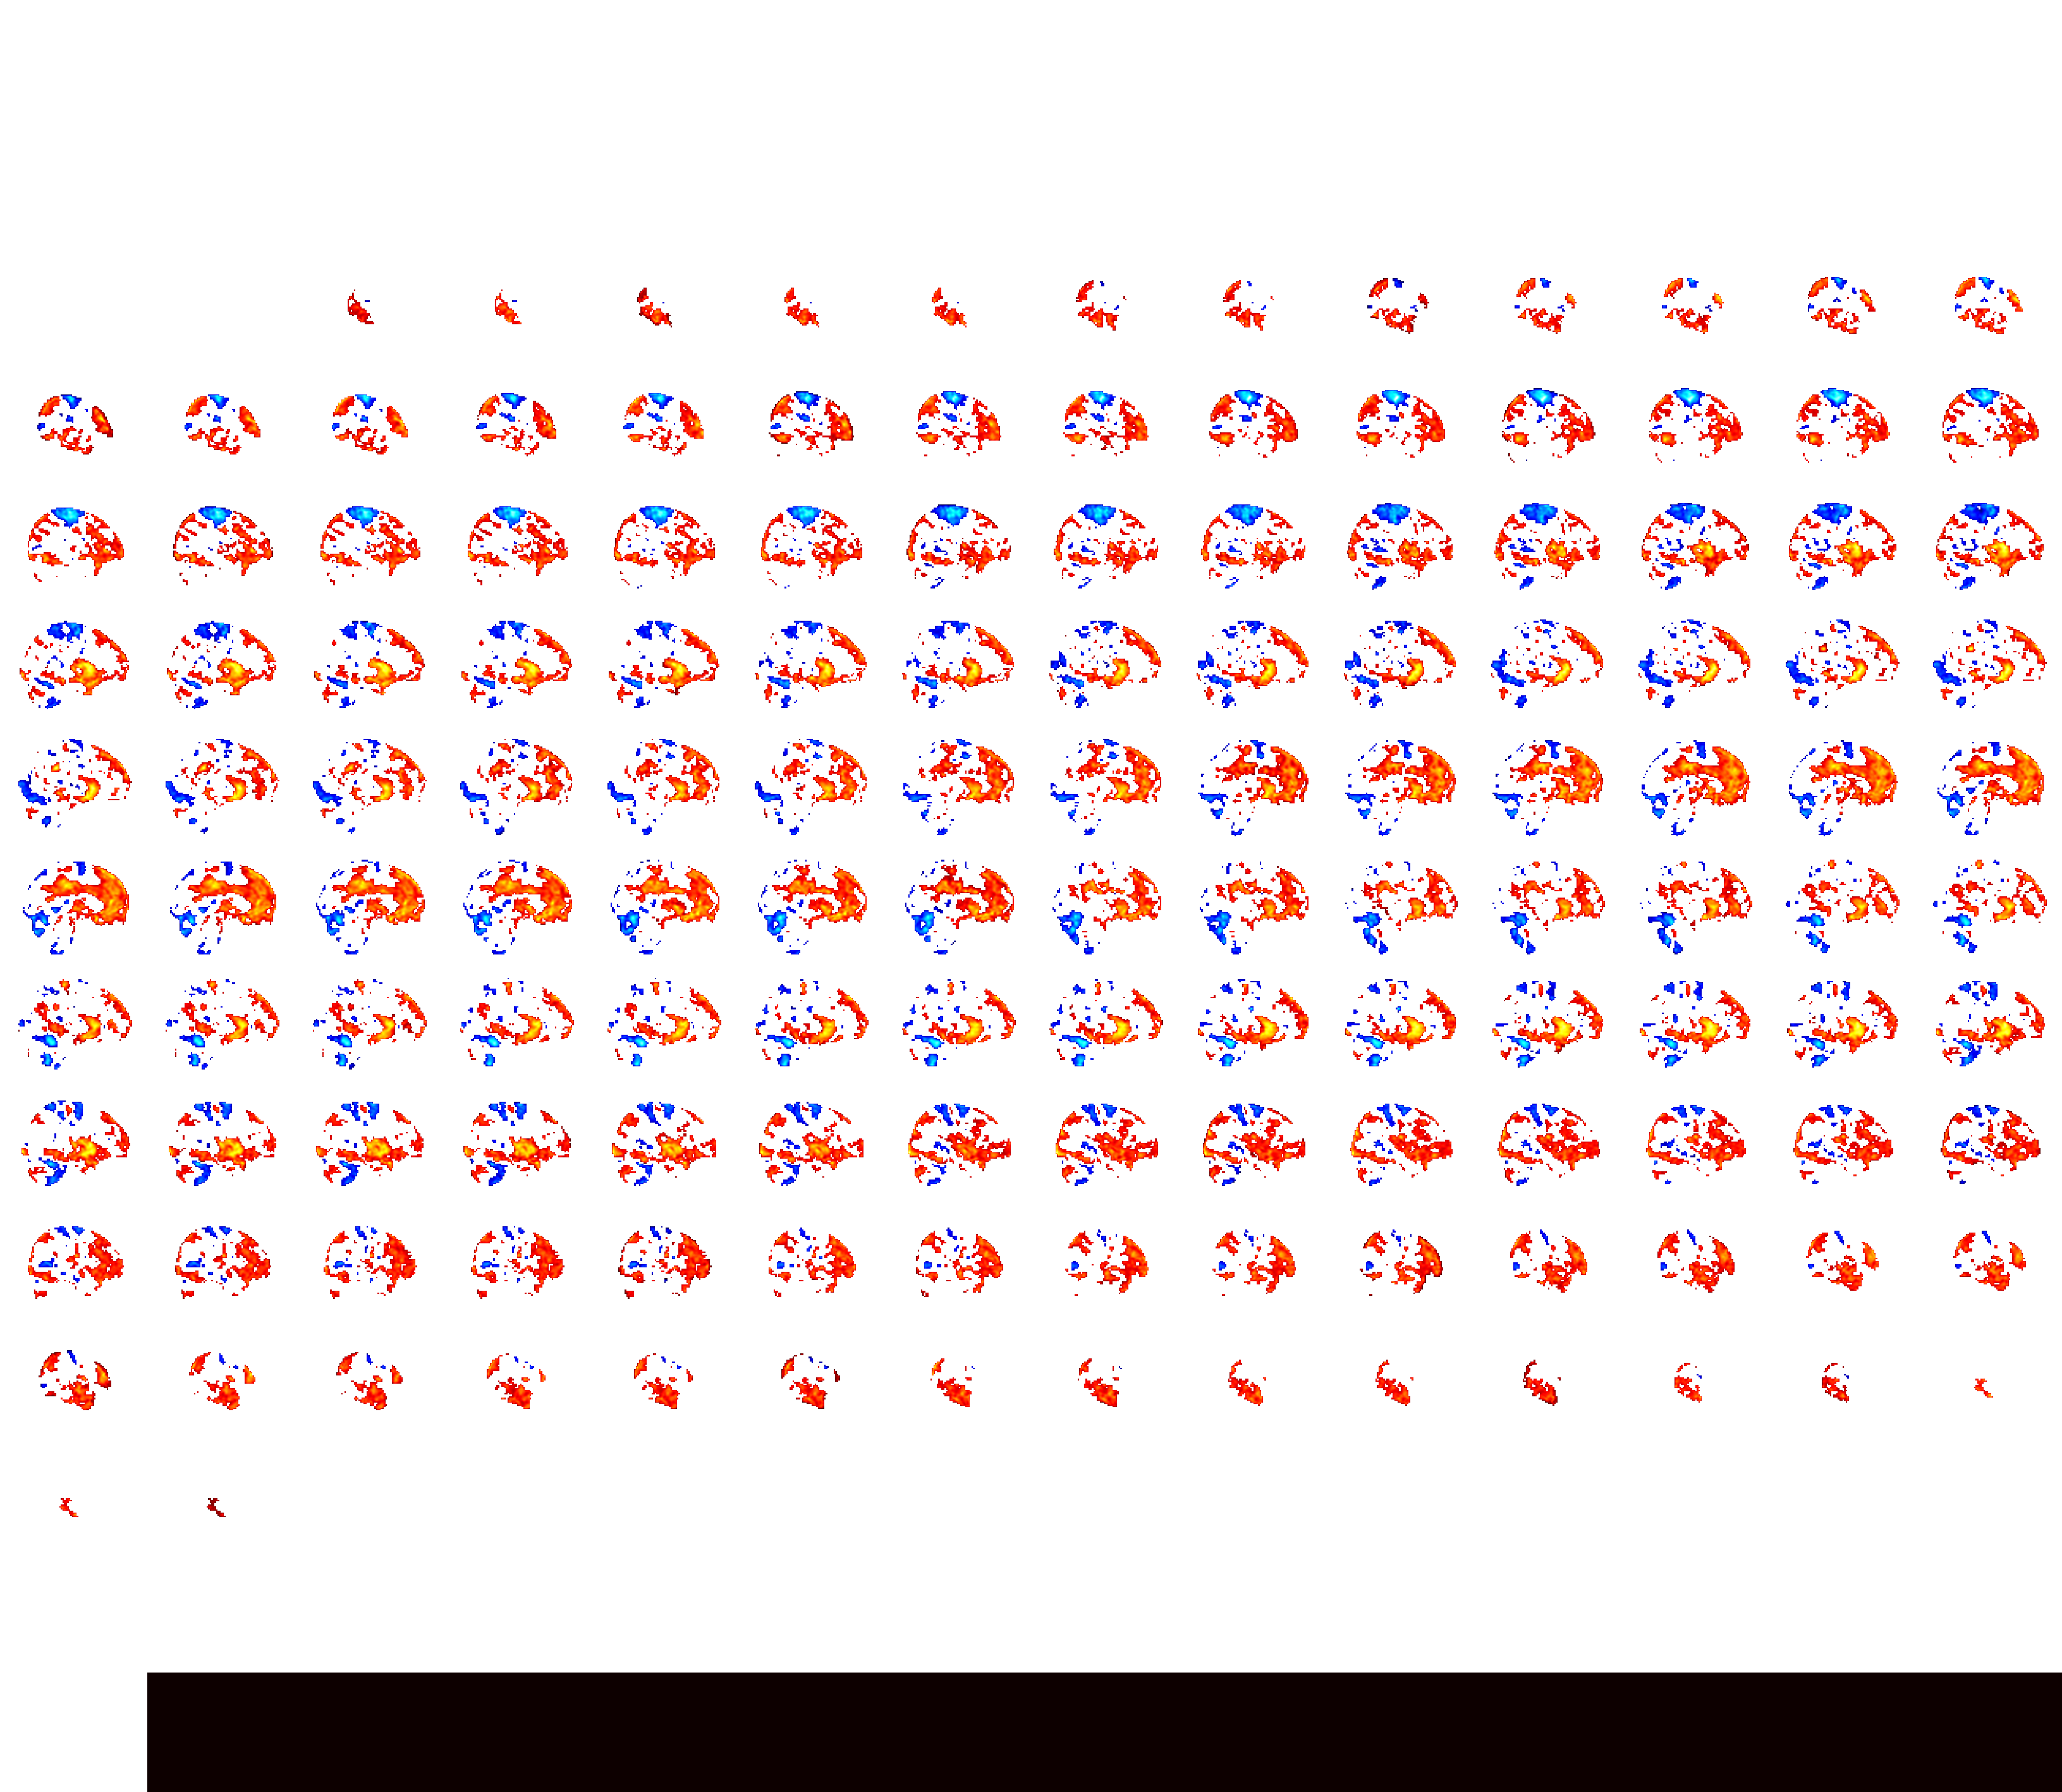

In [18]:
group = 'DLPFC_cTBS'
fname_Zscr = glob(join(dir_stat,'Zstat.%s.%s.n??.nii'%(run,group)))[0]
plotting.view_img(
    fname_Zscr
    , threshold=thresh
)

/usr/local/fsl/lib/python3.10/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



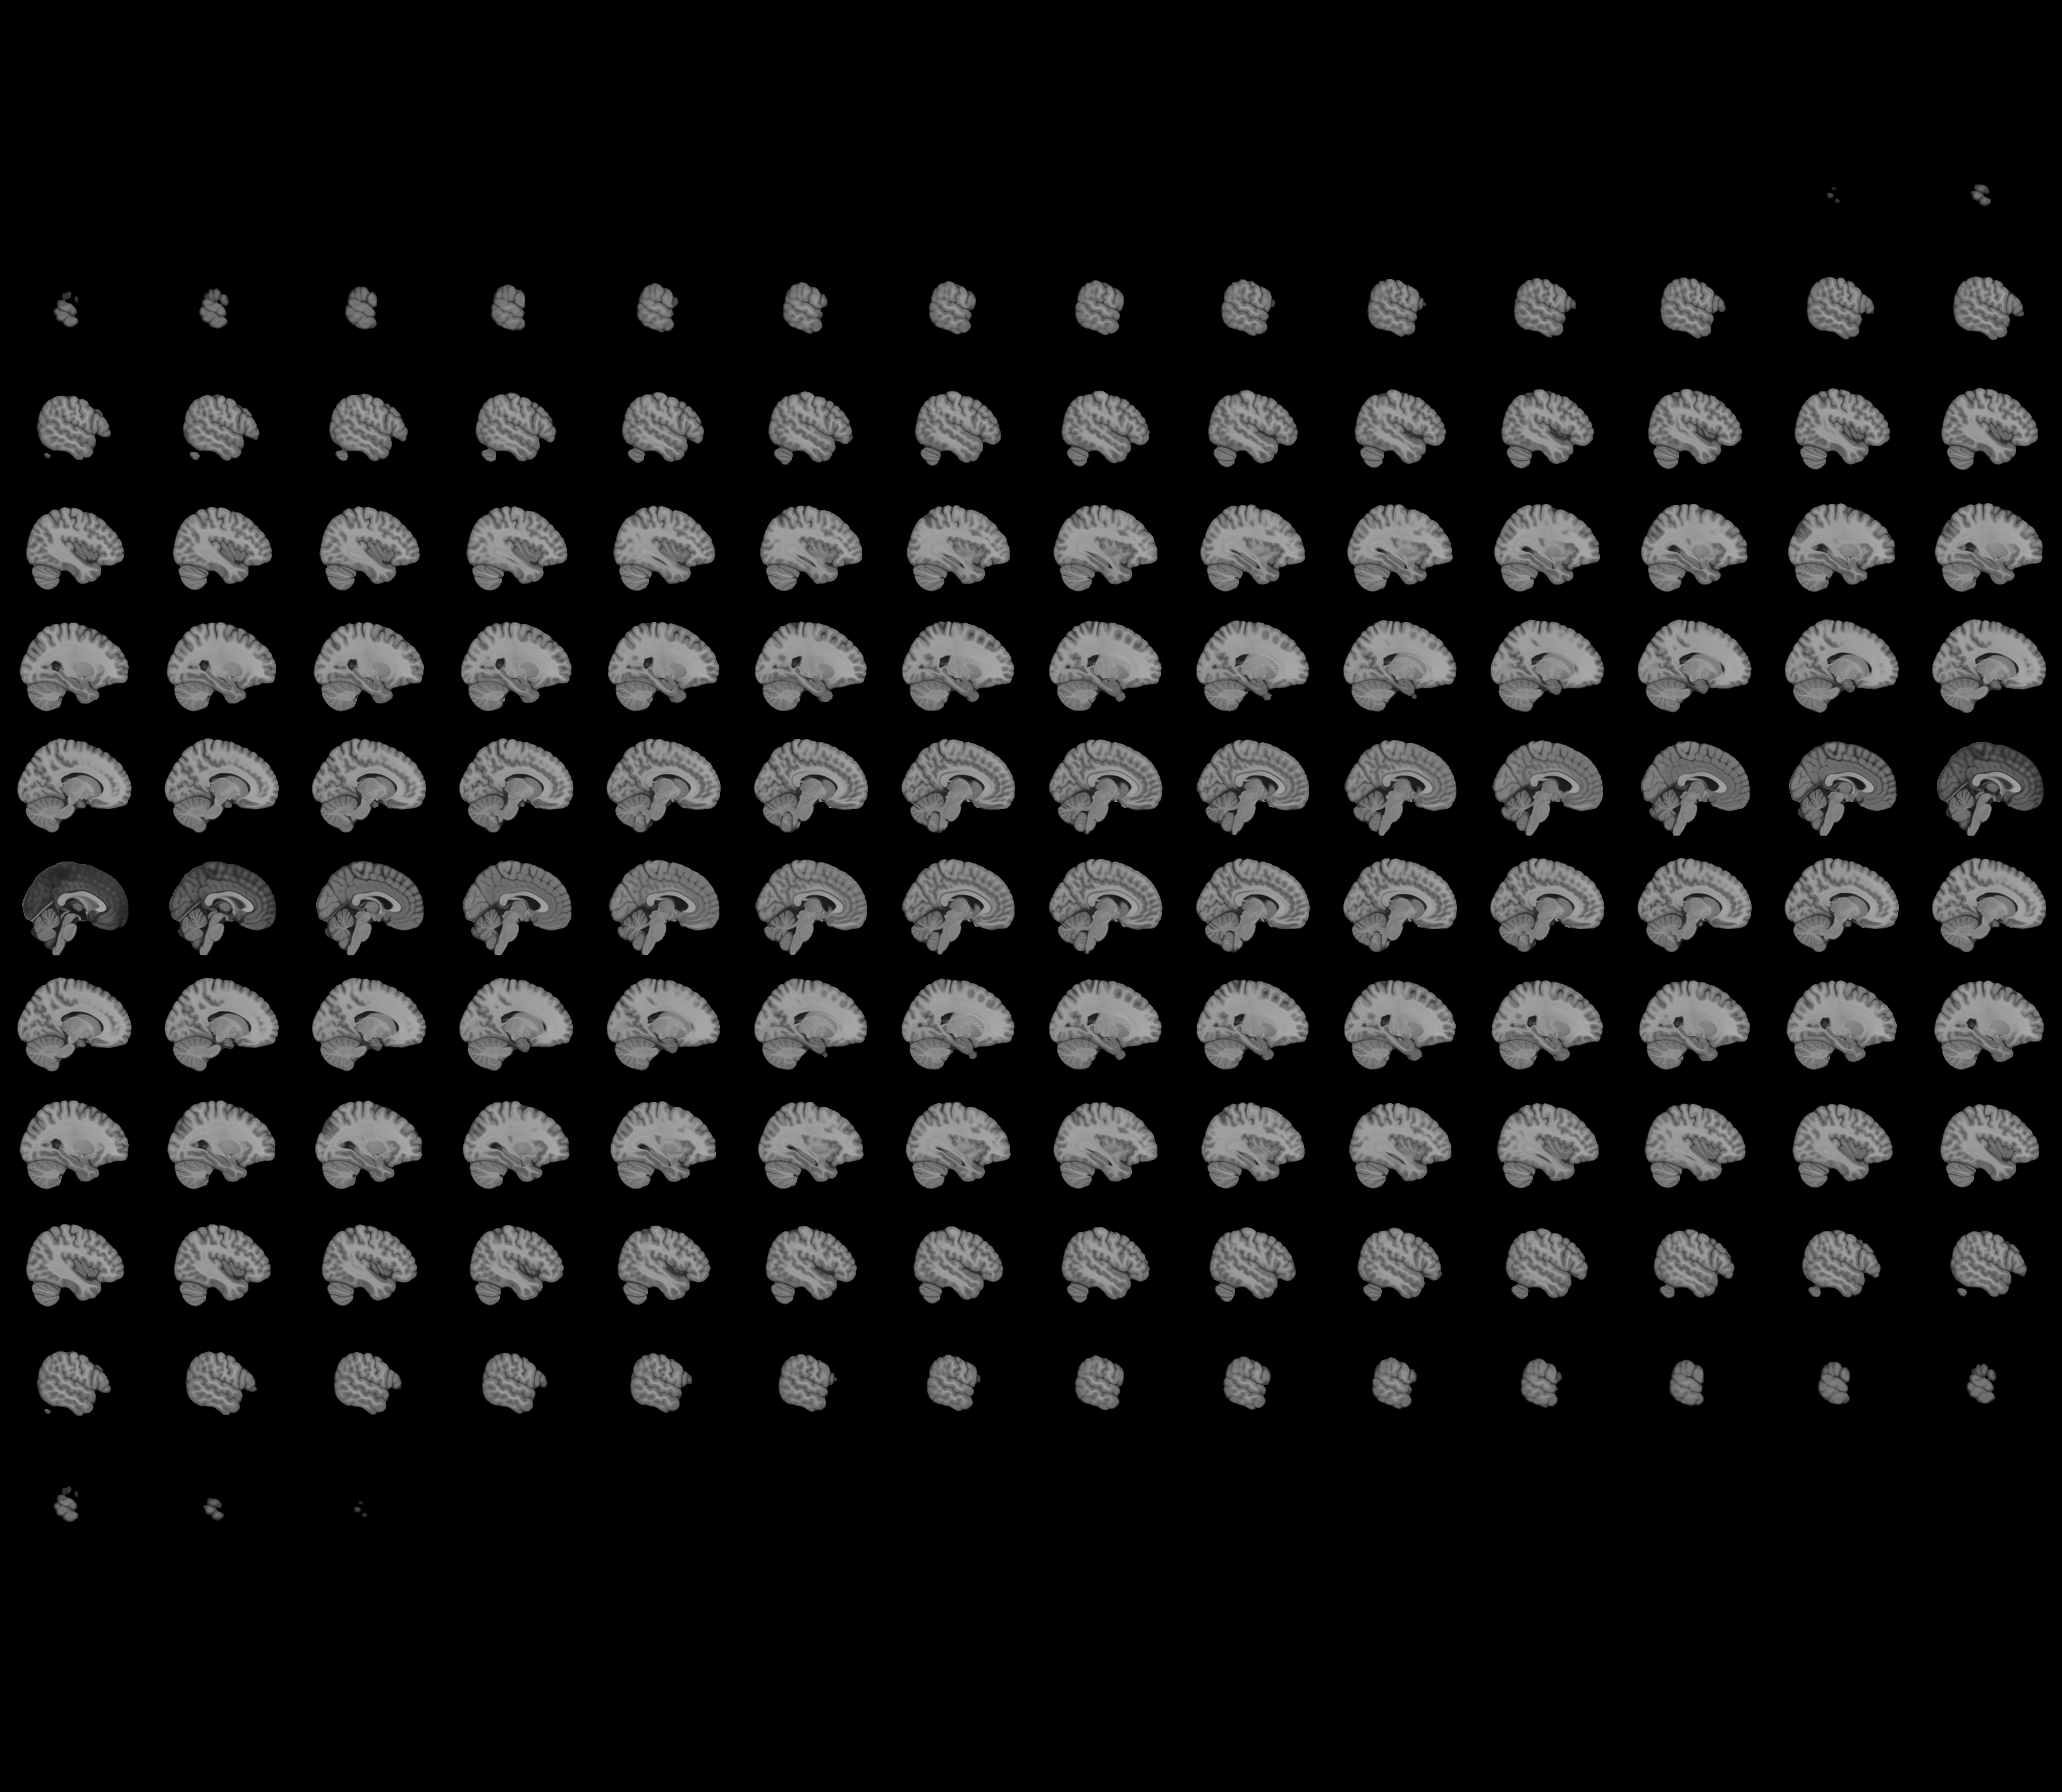
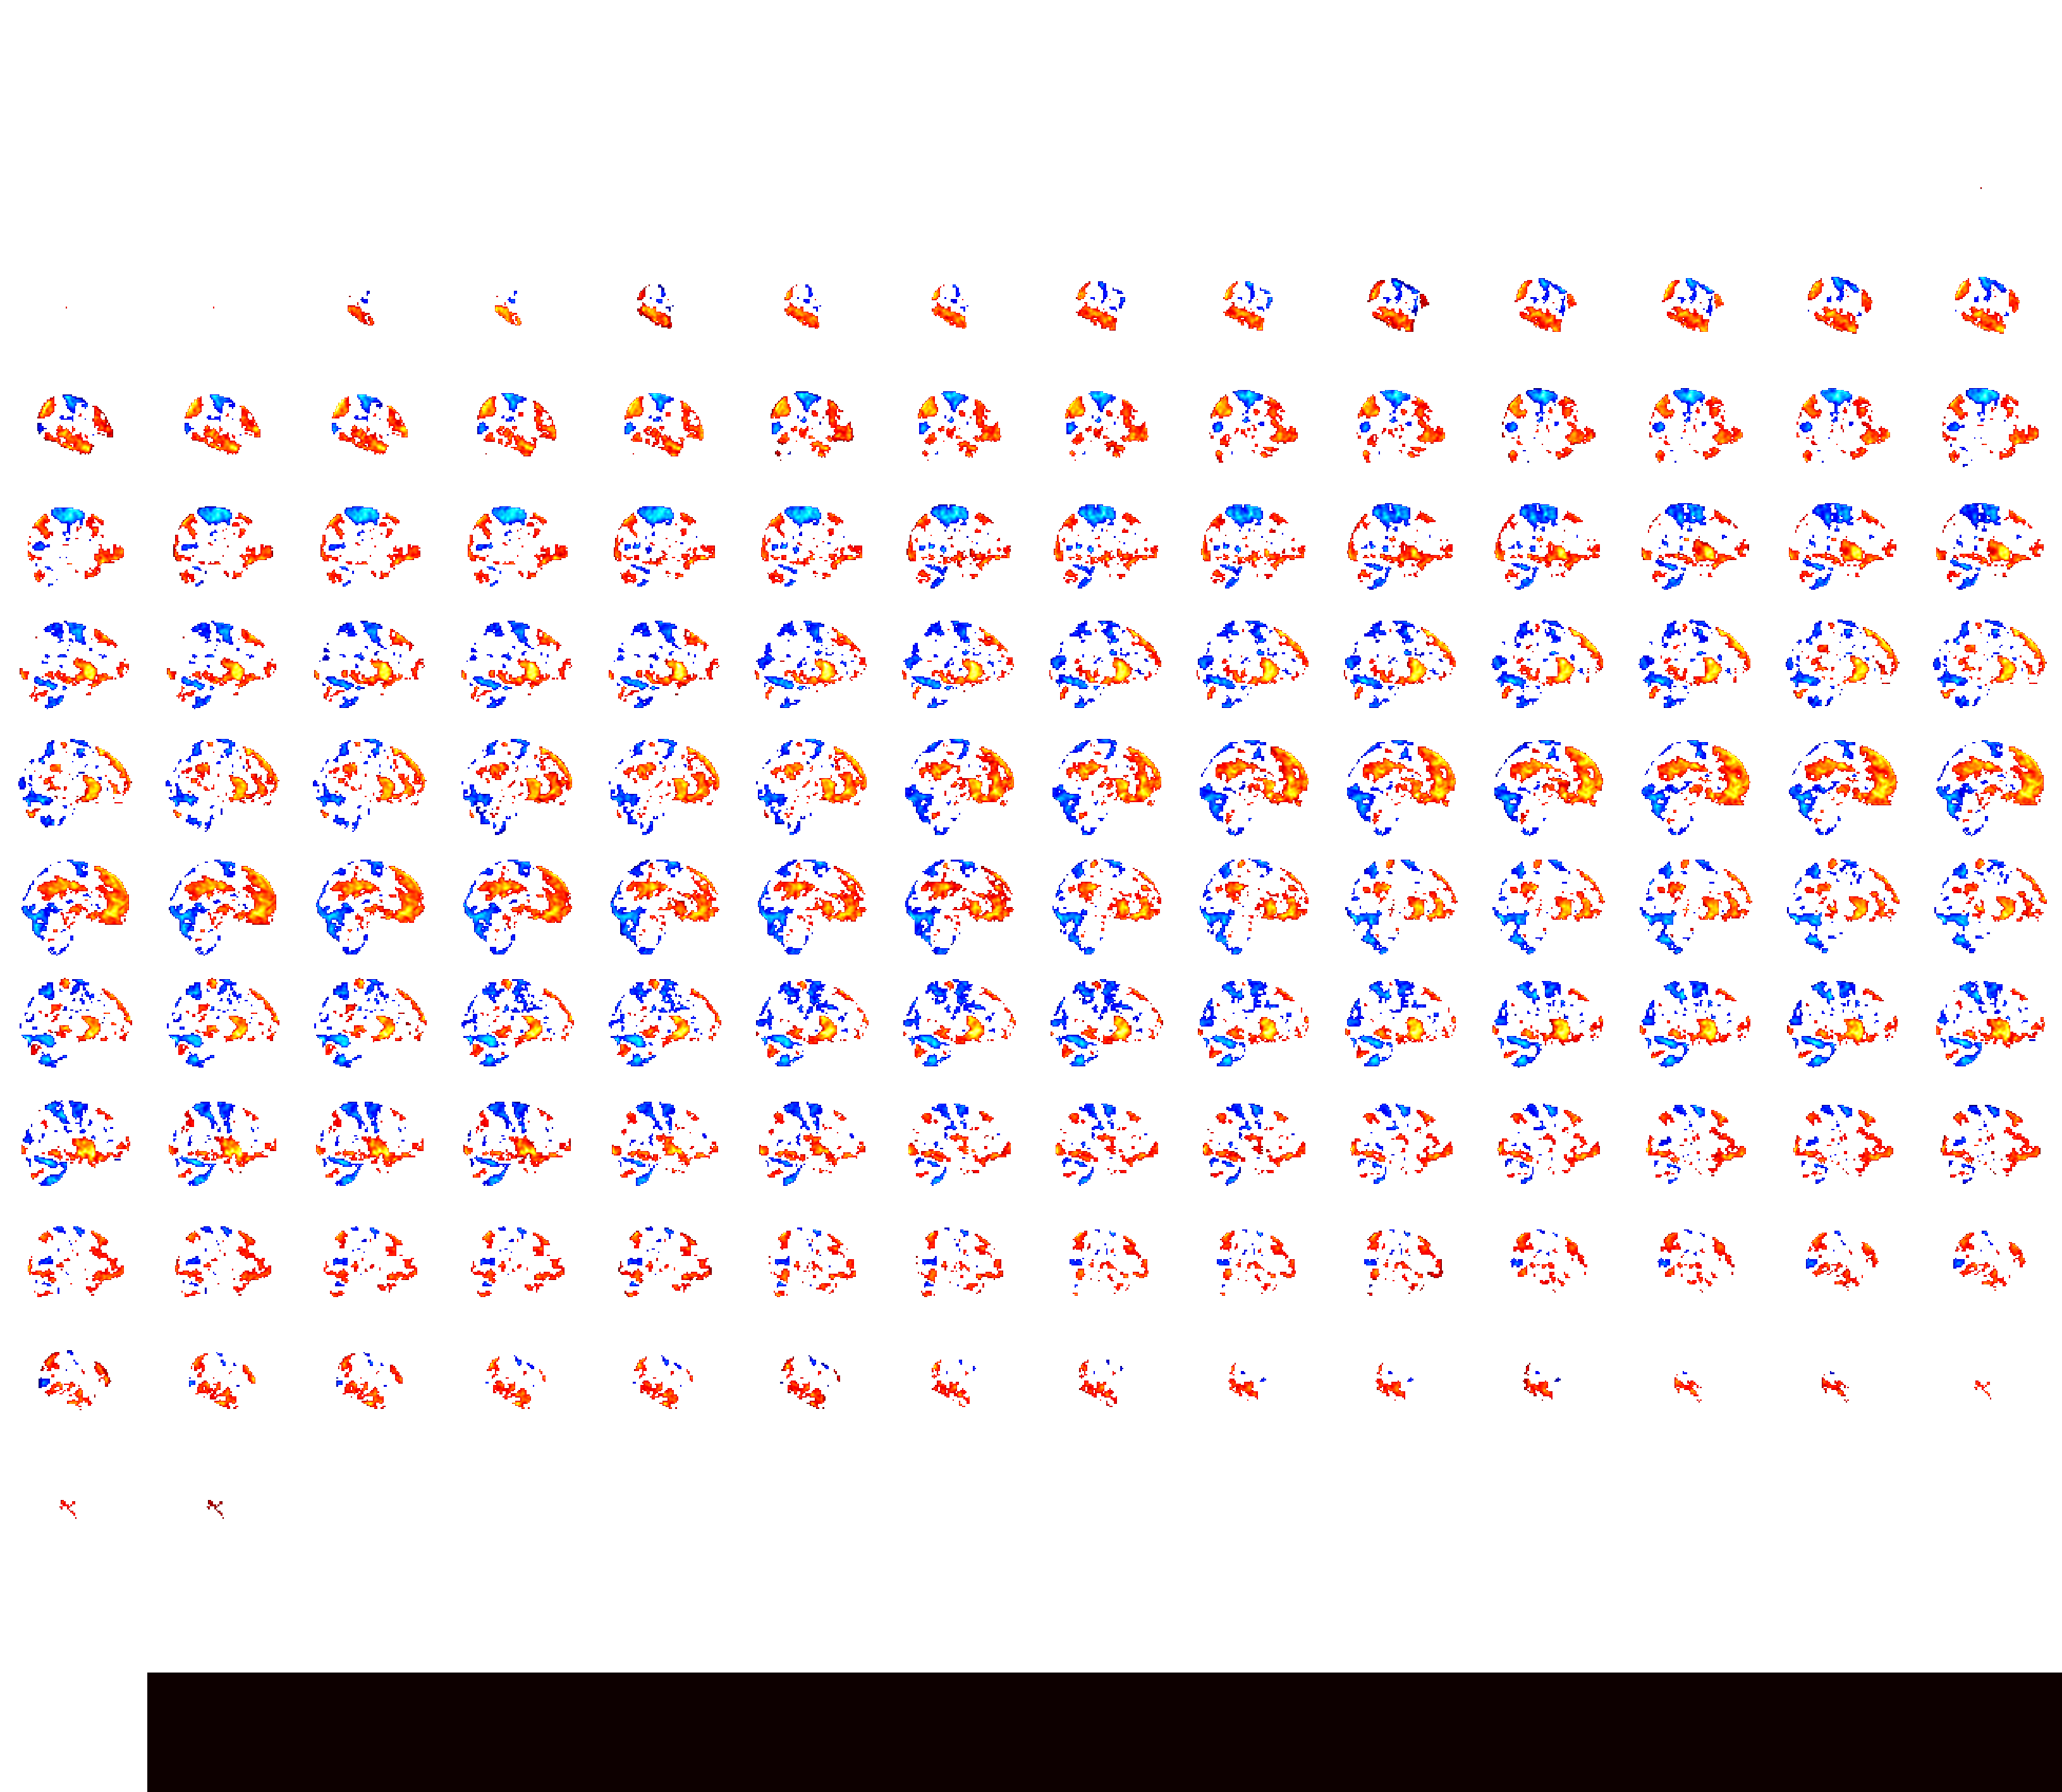

In [19]:
group = 'M1_cTBS'
fname_Zscr = glob(join(dir_stat,'Zstat.%s.%s.n??.nii'%(run,group)))[0]
plotting.view_img(
    fname_Zscr
    , threshold=thresh
)

---

In [16]:
prop = 'Rew#1_Coef'
list_run = ['r%02d'%(rr+1) for rr in range(3)]

In [61]:
df = pd.DataFrame()

for run in list_run:
    print(run)
    
    ## group data
    a = sorted(glob(join(
            '/mnt/ext5/GA/fmri_data/stats/AM/GLM.reward_per_trial/5.0s_shifted'
            , 'GA??/%s.%s.GA??.nii'%(prop,run)
        )))
    p = sorted(glob(join(dir_stat,'GP??/%s.%s.GP??.nii'%(prop,run))))
    list_fname = np.concatenate([a,p])

    for fname in tqdm(list_fname):
        subj = fname.split('/')[-2]
        nn=subj[2:]

        group = dz.loc[subj,'group']

#         beta = masking.apply_mask(imgs=fname, mask_img=img)
        betas = masker.fit_transform(fname)[0]
        for ii, roi in enumerate(labels):
            new_row = pd.Series(
                {
                    'subj':subj, 'group':group, 'run':run,
                    'roi':roi, 'beta':betas[ii]
                }
            )
            df = pd.concat(
                [df, new_row.to_frame().T]
                , axis='index'
                , ignore_index=True
            )
df.set_index('subj', inplace=True)
df.index.name = None
df

r01


100%|██████████| 75/75 [00:00<00:00, 75.51it/s]


r02


100%|██████████| 75/75 [00:00<00:00, 80.21it/s]


r03


100%|██████████| 75/75 [00:00<00:00, 80.39it/s]


group  run   roi      beta
GA01     no_stim  r01  raPU  0.518611
GA01     no_stim  r01  laPU  0.599993
GA01     no_stim  r01  lpPU  0.151185
GA01     no_stim  r01  rpPU  0.272298
GA01     no_stim  r01  laCA  0.538827
...          ...  ...   ...       ...
GP67  DLPFC_cTBS  r03  rpPU  0.018424
GP67  DLPFC_cTBS  r03  laCA  0.016947
GP67  DLPFC_cTBS  r03  lpCA -0.135706
GP67  DLPFC_cTBS  r03  raCA -0.021755
GP67  DLPFC_cTBS  r03  rpCA -0.045155

[1800 rows x 4 columns]

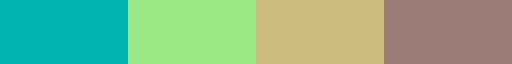

In [62]:
tmp = cm.terrain(np.linspace(0.2, 0.8, 4))
palette = [colors.to_rgba(rgb, alpha=1) for rgb in tmp]

colors.ListedColormap(palette)

raPU
DLPFC_cTBS (r01 vs. r02): 0.00755 (**)
-0.04 0.96 0.7101253006508409 0.47456940433741823
DLPFC_cTBS (r01 vs. r03): 0.00006 (****)
-0.04 1.96 0.7101253006508409 0.32164721725265644
DLPFC_cTBS (r02 vs. r03): 0.01132 (*)
0.96 1.96 0.47456940433741823 0.32164721725265644
M1_cTBS (r01 vs. r03): 0.01963 (*)
0.0 2.0 0.6329771037668729 0.4948786797322575
M1_cTBS (r02 vs. r03): 0.01554 (*)
1.0 2.0 0.6356458625830964 0.4948786797322575

laPU
DLPFC_cTBS (r01 vs. r02): 0.00022 (***)
-0.04 0.96 0.6794869664044646 0.39659914783327976
DLPFC_cTBS (r01 vs. r03): 0.00006 (****)
-0.04 1.96 0.6794869664044646 0.2711175257707427
M1_cTBS (r01 vs. r03): 0.03220 (*)
0.0 2.0 0.6819253215035178 0.5509388113911518

lpPU
DLPFC_cTBS (r01 vs. r02): 0.02688 (*)
-0.04 0.96 0.3469472195992046 0.21753372817063735
DLPFC_cTBS (r01 vs. r03): 0.00055 (***)
-0.04 1.96 0.3469472195992046 0.13534174550443423

rpPU
DLPFC_cTBS (r01 vs. r03): 0.00621 (**)
-0.04 1.96 0.36108723641122176 0.18877483377887086
M1_cTBS (r02 vs. r

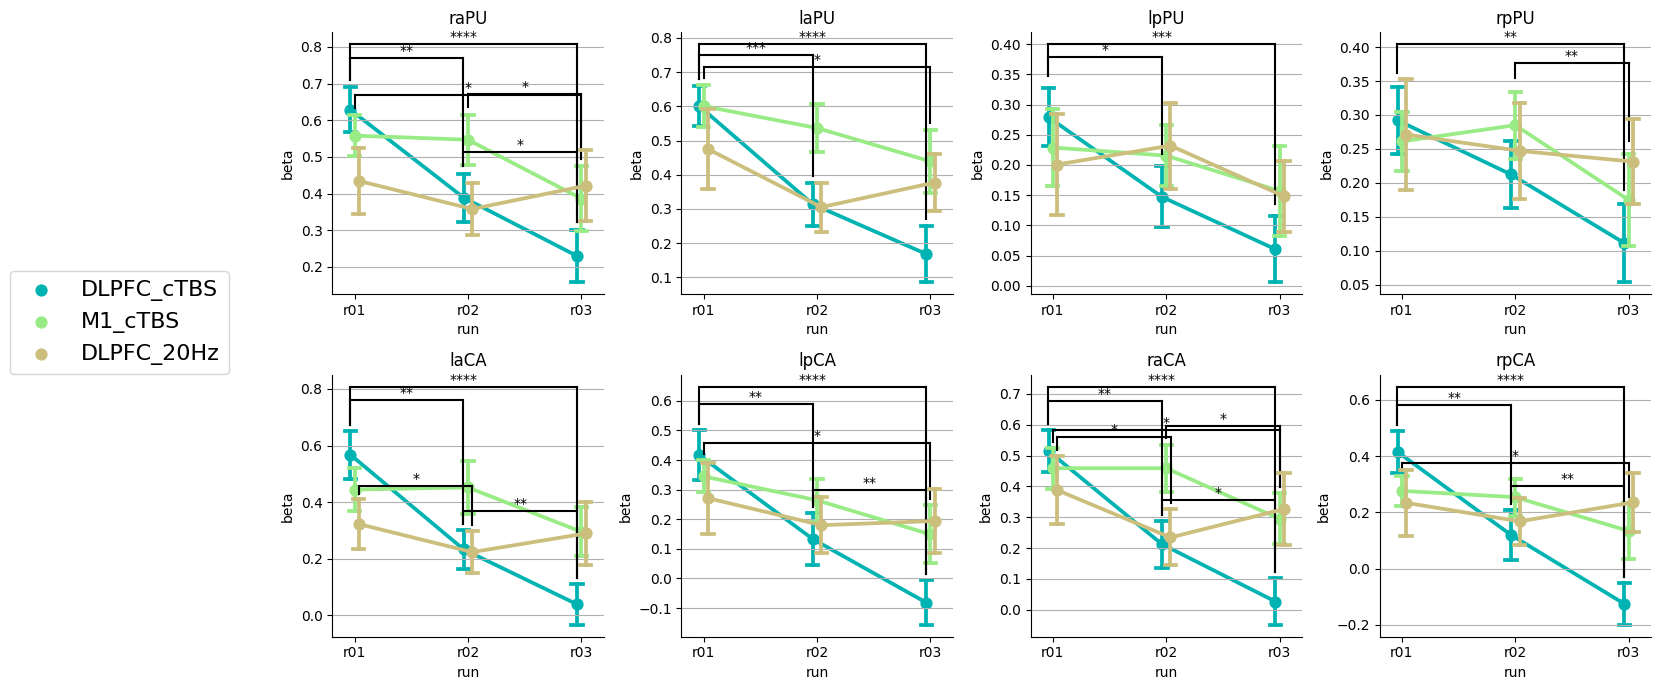

In [67]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(14,7))
axs = np.concatenate(axs)

dy = 0.02
for ii, roi in enumerate(labels):
    ax = axs[ii]
    print(roi)
    g = sns.pointplot(
        data=df[df.roi==roi], x='run', y='beta', hue='group',
        hue_order=['DLPFC_cTBS','M1_cTBS','DLPFC_20Hz'], palette=palette,
        errorbar='se', capsize=0.1,
        dodge=True,
        ax=ax
    )
    g.legend().remove()
    g.grid(axis='y')
    g.set_title(roi)

    for xx, group in enumerate(['DLPFC_cTBS','M1_cTBS','DLPFC_20Hz']):
        dx = 0.04*(-1+xx)
        for ii, r1 in enumerate(list_run):
            x1 = ii + dx
            a = df[(df.roi==roi)&(df.group==group)&(df.run==r1)].beta
            y1 = a.mean()+a.sem() + dy
            for jj, r2 in enumerate(list_run[ii+1:]):
                x2 = jj+ii+1 + dx
                b = df[(df.roi==roi)&(df.group==group)&(df.run==r2)].beta
                y2 = b.mean()+b.sem() + dy
                tval, pval = stats.ttest_rel(a.astype(float),b.astype(float))
                if pval < 0.05:
                    print('%s (%s vs. %s): %.5f (%s)'%(group,r1,r2,pval,convert_pvalue_to_asterisks(pval)))
                    print(x1,x2,y1,y2)
                    y = max(y1,y2) + 0.25*abs(y1-y2)
                    g.plot([x1,x1],[y1,y],'k-')
                    g.plot([x2,x2],[y2,y],'k-')
                    g.plot([x1,x2],[y,y],'k-')
                    g.text(
                        0.5*(x1+x2), y, convert_pvalue_to_asterisks(pval),
                        ha='center', va='bottom', rotation=0, size=10
                    )
    print('')
    
sns.despine()
fig.tight_layout()
g.legend(bbox_to_anchor=(-4.2, 1.2), loc='center right', ncol=1, fontsize=16)

In [68]:
fig.savefig(
    '/home/sungbeenpark/Github/labs/GP/results/fMRI.fig_3-b.png',
    dpi=300, facecolor=[1,1,1,1],
    bbox_inches='tight'
)

---

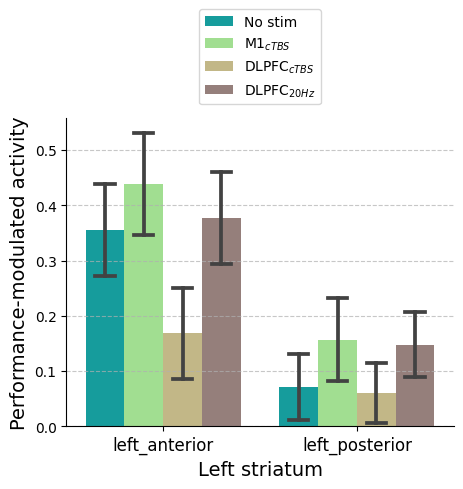

In [21]:
fig, ax = plt.subplots(figsize=(5,4))

g = sns.barplot(
    data=df, x='roi', y='beta', hue='group'
    , hue_order=('no_stim', 'M1_cTBS', 'DLPFC_cTBS', 'DLPFC_20Hz')
#     , order=['left_anterior','left_posterior']
    , palette=palette
    , errorbar='se', capsize=0.1
    , ax=ax
)
g.set_xlabel('Left striatum', fontsize=14)

list_roi = g.get_xticklabels()
g.set_xticklabels(list_roi, fontsize=12, rotation=0)
# g.set_xticklabels(['Anterior','Posterior'], fontsize=12, rotation=0)
g.set_ylabel('Performance-modulated activity', fontsize=14)
g.grid(axis='y', linestyle='--', alpha=0.7)
g.legend(bbox_to_anchor=(0.5, 1.2), loc='center', ncol=1)
# g.legend(loc='best')

list_group = g.get_legend_handles_labels()[-1]
for ii, text in enumerate(list_group):
    if ii==0:
        text_new = 'No stim'
    else:
        a, b = text.split('_')
        text_new = r'%s$_{%s}$'%(a.upper(),b)
    g.legend_.texts[ii].set_text(text_new)

# ## Bounding box
# bbox = g.get_position()
# rect = (0.4, 0.6, 0.55, 0.3) # (x0, y0, w, h)
# ax_insert = fig.add_axes(rect)
# nilearn.plotting.plot_roi(
#     img_roi
#     , display_mode='ortho', draw_cross=False
# #     , cut_coords=[0, 40, 10]
#     , axes=ax_insert
# )

sns.despine()

In [22]:
list_label = []
for aa in list_group:
    for bb in list_roi:
        list_label.append((aa,bb.get_text()))

list_rect = []
list_line = []
for child in g.get_children():
    if type(child) is patches.Rectangle:
        list_rect.append(child)
    elif type(child) is lines.Line2D:
        list_line.append(child)
list_rect = list_rect[:8]
list_line = list_line[:3*8]

dict_rect = {}
for label, rect in zip(list_label, list_rect):
    print(label, rect)
    dict_rect[label] = rect

dict_line = {}
for ii, label in enumerate(list_label):
    for jj, line in enumerate(list_line[ii*3:(ii+1)*3]):
        kk = 'mid' if jj==0 else ('bottom' if jj==1 else ('top' if jj==2 else 'invalid'))
#         print(label, line)
        dict_line[(*(label), kk)] = line

del list_label, list_rect, list_line

('no_stim', 'left_anterior') Rectangle(xy=(-0.4, 0), width=0.2, height=0.355599, angle=0)
('no_stim', 'left_posterior') Rectangle(xy=(0.6, 0), width=0.2, height=0.0720092, angle=0)
('M1_cTBS', 'left_anterior') Rectangle(xy=(-0.2, 0), width=0.2, height=0.439163, angle=0)
('M1_cTBS', 'left_posterior') Rectangle(xy=(0.8, 0), width=0.2, height=0.156833, angle=0)
('DLPFC_cTBS', 'left_anterior') Rectangle(xy=(2.77556e-17, 0), width=0.2, height=0.168305, angle=0)
('DLPFC_cTBS', 'left_posterior') Rectangle(xy=(1, 0), width=0.2, height=0.0605571, angle=0)
('DLPFC_20Hz', 'left_anterior') Rectangle(xy=(0.2, 0), width=0.2, height=0.377255, angle=0)
('DLPFC_20Hz', 'left_posterior') Rectangle(xy=(1.2, 0), width=0.2, height=0.148337, angle=0)


In [23]:
cnt = {}
for roi in df.roi.unique():
    print(roi)
    cnt[roi] = 0
    for ii, g1 in enumerate(list_group):
        for g2 in list_group[ii+1:]:
            kk = 'less' if 'DLPFC' in g1 else ('greater' if 'DLPFC' in g2 else 'two-sided')

            a = df[(df.group==g1)&(df.roi==roi)].beta
            b = df[(df.group==g2)&(df.roi==roi)].beta
            print('%s (%d) vs %s (%d) (%s):'%(g1,len(a),g2,len(b),kk))

            tval, pval = stats.ranksums(
                a.values.astype(float), b.values.astype(float)
                , alternative = kk
            )
            print("%.4f (%s)"%(pval,convert_pvalue_to_asterisks(pval)))
            if pval < 0.05:
                cnt[roi] += 1
    print('')
print(cnt)

left_anterior
no_stim (30) vs M1_cTBS (17) (two-sided):
0.4650 (ns)
no_stim (30) vs DLPFC_cTBS (17) (greater):
0.0270 (*)
no_stim (30) vs DLPFC_20Hz (11) (greater):
0.6044 (ns)
M1_cTBS (17) vs DLPFC_cTBS (17) (greater):
0.0186 (*)
M1_cTBS (17) vs DLPFC_20Hz (11) (greater):
0.4532 (ns)
DLPFC_cTBS (17) vs DLPFC_20Hz (11) (less):
0.0475 (*)

left_posterior
no_stim (30) vs M1_cTBS (17) (two-sided):
0.5500 (ns)
no_stim (30) vs DLPFC_cTBS (17) (greater):
0.2127 (ns)
no_stim (30) vs DLPFC_20Hz (11) (greater):
0.7507 (ns)
M1_cTBS (17) vs DLPFC_cTBS (17) (greater):
0.0868 (ns)
M1_cTBS (17) vs DLPFC_20Hz (11) (greater):
0.4346 (ns)
DLPFC_cTBS (17) vs DLPFC_20Hz (11) (less):
0.1921 (ns)

{'left_anterior': 3, 'left_posterior': 0}


left_anterior
no_stim (30) vs M1_cTBS (17) (two-sided):
0.4650 (ns)
no_stim (30) vs DLPFC_cTBS (17) (greater):
0.0270 (*)
no_stim (30) vs DLPFC_20Hz (11) (greater):
0.6044 (ns)
M1_cTBS (17) vs DLPFC_cTBS (17) (greater):
0.0186 (*)
M1_cTBS (17) vs DLPFC_20Hz (11) (greater):
0.4532 (ns)
DLPFC_cTBS (17) vs DLPFC_20Hz (11) (less):
0.0475 (*)

left_posterior
no_stim (30) vs M1_cTBS (17) (two-sided):
0.5500 (ns)
no_stim (30) vs DLPFC_cTBS (17) (greater):
0.2127 (ns)
no_stim (30) vs DLPFC_20Hz (11) (greater):
0.7507 (ns)
M1_cTBS (17) vs DLPFC_cTBS (17) (greater):
0.0868 (ns)
M1_cTBS (17) vs DLPFC_20Hz (11) (greater):
0.4346 (ns)
DLPFC_cTBS (17) vs DLPFC_20Hz (11) (less):
0.1921 (ns)



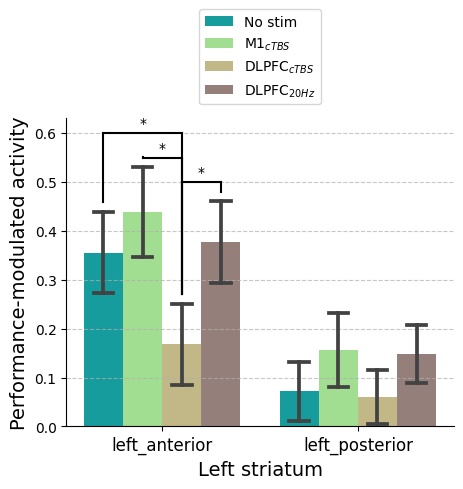

In [24]:
yApart = 0.02

for roi in df.roi.unique():
    print(roi)
    tmp = [0.5+0.05*ii for ii in range(cnt[roi])]
    for ii, g1 in enumerate(list_group):
        for g2 in list_group[ii+1:]:
            kk = 'less' if 'DLPFC' in g1 else ('greater' if 'DLPFC' in g2 else 'two-sided')

            a = df[(df.group==g1)&(df.roi==roi)].beta
            b = df[(df.group==g2)&(df.roi==roi)].beta
            print('%s (%d) vs %s (%d) (%s):'%(g1,len(a),g2,len(b),kk))

            tval, pval = stats.ranksums(
                a.values.astype(float), b.values.astype(float)
                , alternative = kk
            )
            print("%.4f (%s)"%(pval,convert_pvalue_to_asterisks(pval)))
            
            if pval < 0.05:
                cnt[roi] -= 1
                [x10,y10],[x11,y11] = np.array(dict_rect[(g1,roi)].get_bbox())
                x1 = (x10+x11)*0.5
                [x20,y20],[x21,y21] = np.array(dict_rect[(g2,roi)].get_bbox())
                x2 = (x20+x21)*0.5
                
                yUEdge = tmp[cnt[roi]]
                g.plot([x1, x1], [a.mean()+(a.sem()+yApart), yUEdge], 'k-')
                g.plot([x2, x2], [b.mean()+(b.sem()+yApart), yUEdge], 'k-')
                g.plot([x1, x2], [yUEdge, yUEdge], 'k-')
                g.text(
                    (x1+x2)*0.5, yUEdge+(0.02), convert_pvalue_to_asterisks(pval)
                    , ha='center', va='center', rotation=0, size=10
                )
    print('')
fig

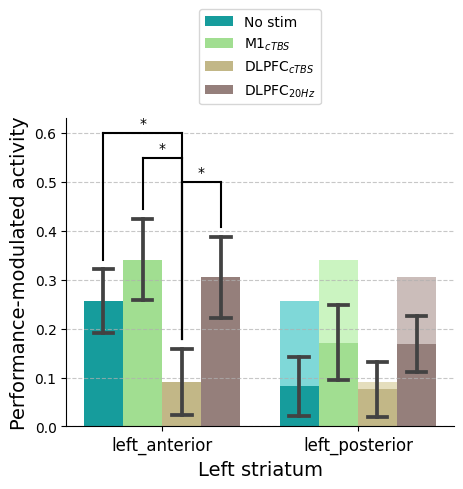

In [23]:
for ii, group in enumerate(list_group):
    width = dict_rect[(group,'left_anterior')].get_width()
    h1 = dict_rect[(group,'left_anterior')].get_height()
    h2 = dict_rect[(group,'left_posterior')].get_height()
    height = h1 - h2
    x2 = dict_rect[(group,'left_posterior')].get_x()
    xy = (x2, h2)
    color = (*palette[ii][:3], 0.5)
    g.add_patch(patches.Rectangle(
        xy=xy, width=width, height=height
        , facecolor=color, edgecolor=None
#         , hatch='o'
    ))
fig

In [24]:
cnt['diff'] = 0
r1, r2 = 'anterior', 'posterior'
print("%s vs. %s"%(r1, r2))
list_ = g.get_legend_handles_labels()[-1]
for ii, g1 in enumerate(list_):
    for g2 in list_[ii+1:]:
        print('%s vs %s'%(g1,g2))
        kk = 'greater' if 'M1' in g1 else ('less' if 'M1' in g2 else 'two-sided')
        
        a = df[(df.group==g1)&(df.roi=='left_anterior')].beta
        b = df[(df.group==g1)&(df.roi=='left_posterior')].beta

        c = df[(df.group==g2)&(df.roi=='left_anterior')].beta
        d = df[(df.group==g2)&(df.roi=='left_posterior')].beta

        tval, pval = stats.ttest_ind(
            (a-b).values.astype(float), (c-d).values.astype(float)
            , alternative = kk
        )
        print("%.4f (%s)"%(pval,convert_pvalue_to_asterisks(pval)))
        tval, pval = stats.ranksums(
            (a-b).values.astype(float), (c-d).values.astype(float)
            , alternative = kk
        )
        print("%.4f (%s)"%(pval,convert_pvalue_to_asterisks(pval)))
        if pval < 0.05:
            cnt['diff'] += 1
cnt

anterior vs. posterior
no_stim vs M1_cTBS
0.5302 (ns)
0.3451 (ns)
no_stim vs DLPFC_cTBS
0.0019 (**)
0.0018 (**)
no_stim vs DLPFC_20Hz
0.5731 (ns)
0.3464 (ns)
M1_cTBS vs DLPFC_cTBS
0.0101 (*)
0.0069 (**)
M1_cTBS vs DLPFC_20Hz
0.3535 (ns)
0.2330 (ns)
DLPFC_cTBS vs DLPFC_20Hz
0.1121 (ns)
0.2126 (ns)


{'left_anterior': 0, 'left_posterior': 0, 'diff': 2}

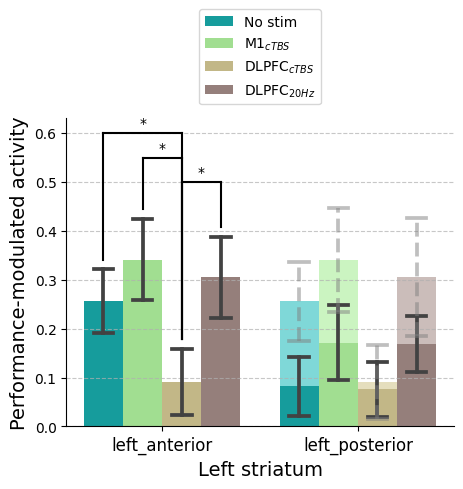

In [25]:
dict_ = {}
for legend in g.get_legend_handles_labels()[-1]:
    a = df[(df.group==legend)&(df.roi=='left_anterior')].beta
    b = df[(df.group==legend)&(df.roi=='left_posterior')].beta
    mean = (a-b).mean()
    std = (a-b).std()
    dy = std*0.5

    ref_bottom = dict_line[(legend, 'left_posterior', 'bottom')].get_bbox()
    x0 = ref_bottom.x0
    x1 = ref_bottom.x1
    xm = (x0+x1)*0.5

    ref_mid = dict_line[(legend, 'left_posterior', 'mid')].get_bbox()
    h = (ref_mid.y0+ref_mid.y1)*0.5 + mean

    width = dict_line[(legend, 'left_posterior', 'mid')].get_linewidth()

    mid = [[xm,xm],[h-dy,h+dy]]
    g.add_line(lines.Line2D(mid[0], mid[1], color='gray', alpha=0.5, linewidth=width, linestyle='--'))
    bottom = [[x0,x1],[h-dy,h-dy]]
    g.add_line(lines.Line2D(bottom[0], bottom[1], color='gray', alpha=0.5, linewidth=width, linestyle='-'))
    top = [[x0,x1],[h+dy,h+dy]]
    dict_[legend] = top
    g.add_line(lines.Line2D(top[0], top[1], color='gray', alpha=0.5, linewidth=width, linestyle='-'))

fig

In [ ]:
## t test
yApart = 0.02
roi = 'diff'
for ii, g1 in enumerate(list_group)
    for jj, g2 in enumerate(list_group[ii+1]):
        a = df[(df.group==g1)&(df.roi=='left_anterior')].beta
        b = df[(df.group==g1)&(df.roi=='left_posterior')].beta

        c = df[(df.group==g2)&(df.roi=='left_anterior')].beta
        d = df[(df.group==g2)&(df.roi=='left_posterior')].beta

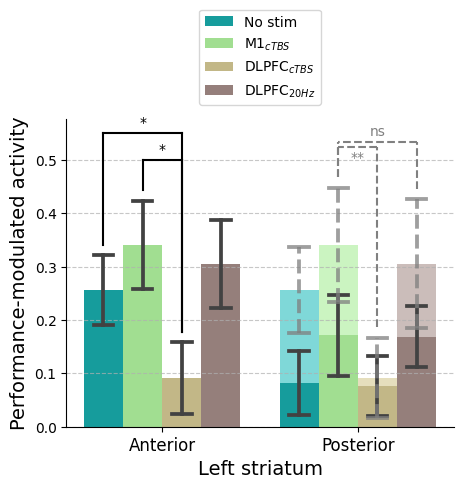

In [42]:
## t test
N = 4
yApart = [-0.02, 0.02]

g2 = 'M1_cTBS'
for ii, g1 in enumerate(['DLPFC_cTBS', 'DLPFC_20Hz']):
    a = df[(df.group==g1)&(df.roi=='left_anterior')].beta
    b = df[(df.group==g1)&(df.roi=='left_posterior')].beta

    c = df[(df.group==g2)&(df.roi=='left_anterior')].beta
    d = df[(df.group==g2)&(df.roi=='left_posterior')].beta
    tval, pval = stats.ranksums(
        (a-b).values.astype(float), (c-d).values.astype(float)
        , alternative='less'
    )

    x1 = (dict_[g1][0][0]+dict_[g1][0][1])*0.5
    x2 = (dict_[g2][0][0]+dict_[g2][0][1])*0.5
    
    yUEdge = tmp[ii]
    g.plot([x1, x1], [dict_[g1][1][0]+0.02, yUEdge], color='gray', linestyle='--')
    g.plot([x2, x2], [dict_[g2][1][0]+0.02, yUEdge], color='gray', linestyle='--')
    g.plot([x1, x2], [yUEdge, yUEdge], color='gray', linestyle='--')
    g.text(
        (x1+x2)*0.5, yUEdge+yApart[ii], convert_pvalue_to_asterisks(pval)
        , ha='center', va='center', rotation=0, size=10
        , color='gray'
    )

g.set_xticklabels(['Anterior', 'Posterior'], fontsize=12)

fig

/home/sungbeenpark/.local/lib/python3.10/site-packages/nilearn/plotting/img_plotting.py:572: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  img = new_img_like(roi_img, data, affine=roi_img.affine)
/tmp/ipykernel_450850/807858559.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


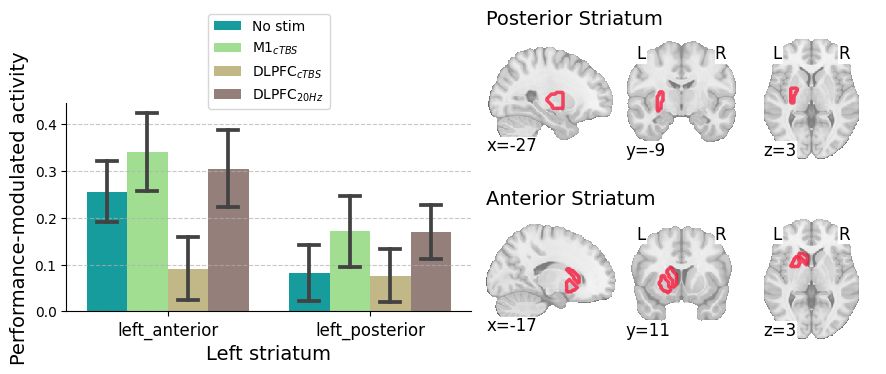

In [35]:
## add rois
w, h = 0.26, 0.3
dy = 0.1
rects = [
    [
        (1, 0+dy ,w, h),
        (1+w, 0+dy ,w, h),
        (1+2*w, 0+dy ,w, h)
    ],
    [
        (1, 0.45+dy ,w, h),
        (1+w, 0.45+dy ,w, h),
        (1+2*w, 0.45+dy ,w, h)
    ]
]
coord = [[-17,11,3], [-27,-9,3]]
for ii, (roi, img) in enumerate(imgs.items()):
    for jj, axis in enumerate(['x','y','z']):
        ax_insert = fig.add_axes(rect=rects[ii][jj])
        plotting.plot_roi(
            img, black_bg=False
            , display_mode=axis
            , cut_coords=[coord[ii][jj]], draw_cross=False
            , view_type='contours', linewidths=2.5
            , cmap='gist_rainbow'
            , axes=ax_insert
        )

for ii, roi in enumerate(['Posterior','Anterior']):
    fig.text(
        x=1, y=0.9 - 0.45*ii
        , s='%s Striatum'%roi
        , fontsize=14
        , horizontalalignment='left'
        , verticalalignment='center'
    )

fig.tight_layout()
fig

In [25]:
fig.savefig(
    '/home/sungbeenpark/Github/labs/GP/results/fMRI.fig_3-b.png'
    , dpi=300, facecolor=[1,1,1,1]
    , bbox_inches = 'tight'
)

---